# BEE 4750 Lab 3 Solution

## Setup

The following code should go at the top of most Julia scripts; it will
load the local package environment and install any needed packages. You
will see this often and shouldn’t need to touch it.

In [1]:
import Pkg
Pkg.activate(".")
Pkg.instantiate()

In [2]:
using JuMP # optimization modeling syntax
using HiGHS # optimization solver
using Plots # plotting

## Overview

In this lab, you will write and solve a resource allocation example
using `JuMP.jl`. `JuMP.jl` provides an intuitive syntax for writing,
solving, and querying optimization problems.

For an example of using `JuMP.jl` to solve linear programs, see [the
relevant tutorial on the class
website](https://viveks.me/environmental-systems-analysis/tutorials/julia-jump.html).

## Introduction

Your task is to decide how much lumber to produce to maximize profit
from wood sales. You can purchase wood from a managed forest, which
consists of spruce (320,000 bf) and fir (720,000 bf). Spruce costs
\$0.12 per bf to purchase and fir costs \$0.08 per bf.

At the lumber mill, wood can be turned into plywood of various grades
(see <a href="#tbl-inputs" class="quarto-xref">Table 1</a> for how much
wood of each type is required for and the revenue from each grade). Any
excess wood is sent to be recycled into particle board. This resource
allocation problem is diagrammed in
<a href="#fig-schematic" class="quarto-xref">Figure 1</a>.

| Plywood Grade | Inputs (bf/bf plywood) | Revenue (\$/1000 bf) |
|:-------------:|:----------------------:|:--------------------:|
|       1       |   0.5 (S) + 1.5 (F)    |         400          |
|       2       |   1.0 (S) + 2.0 (F)    |         520          |
|       3       |   1.5 (S) + 2.0 (F)    |         700          |

Table 1: Wood inputs and revenue by plywood grade. S refers to spruce
inputs, F fir inputs.

<figure id="fig-schematic">
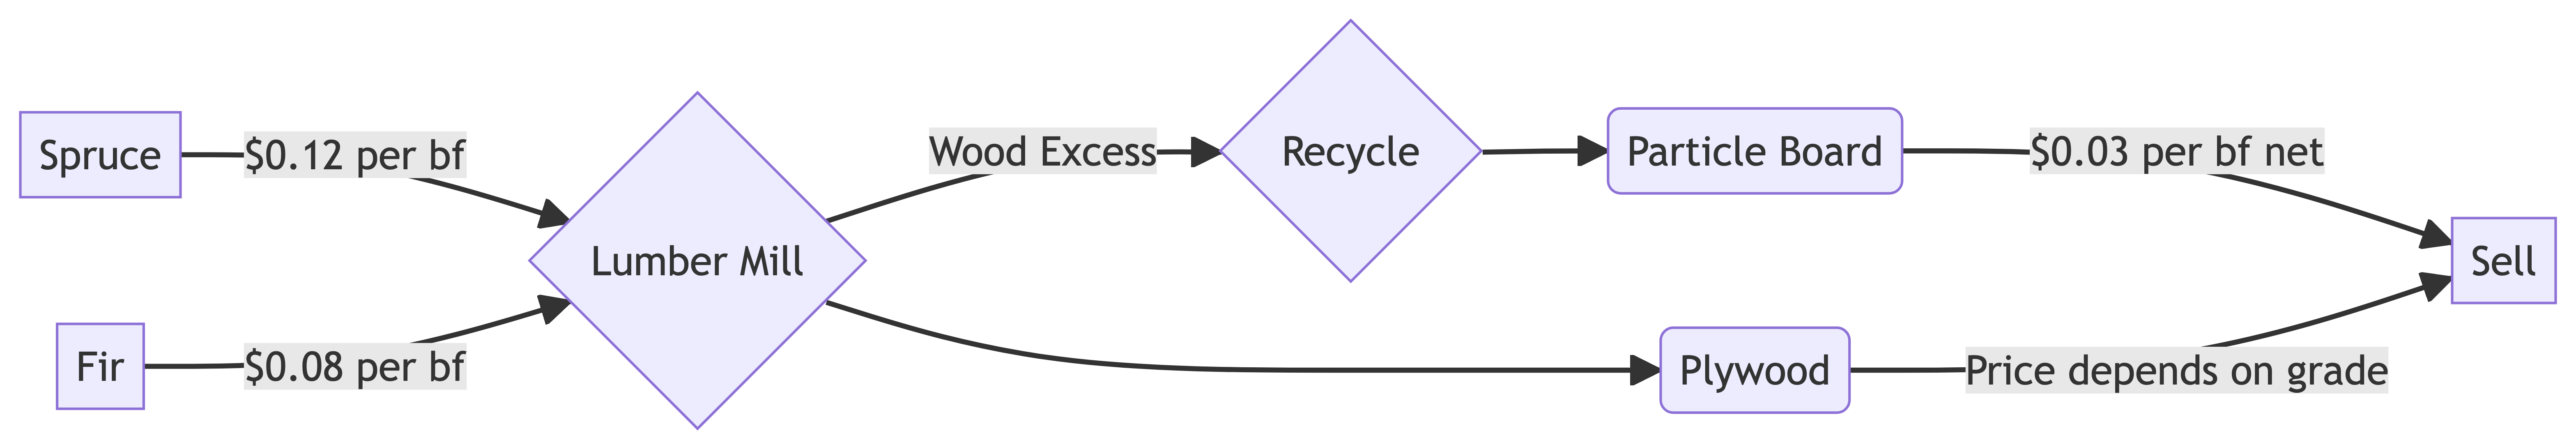
<figcaption>Figure 1: Flowchat of the resource allocation problem in
this lab.</figcaption>
</figure>

## Problems (10 points)

### Problem 1: Problem Formulation (5 points)

In this problem, you will go through the steps of formulating a linear
program for this problem.

#### Problem 1.1 (1 point)

What are your decision variables? Clearly define your notation,
including what variables you are using, what they mean, and what their
units are.

***Solution***:

A good choice for our decision variables are $G_1$, $G_2$, and $G_3$,
each of which correspond to a 1,000 bf of each plywood grade (for
convenience). Note that we may not need to consider the particle board —
it’s money-losing, and will just be where we send excess spruce and fir
(where we have to buy a fraction of a unit).

We don’t have to worry about other notation, as we can express the wood
needs in terms of the plywood grade quantities.

#### Problem 1.2 (1 point)

Derive your objective function. Support your function with
justifications and/or equations as necessary. You will not receive
credit just for the function alone.

***Solution***:

Our objective is to maximize profit, so for each grade of plywood we
want to calculate its profit.

-   Grade 1 (per 1,000 bf):
    $\$400 - (0.5 \times \$120) - (1.5 \times \$80) = \$220$
-   Grade 2 (per 1,000 bf):
    $\$520 - (1 \times \$120) - (2 \times \$80) = \$240$
-   Grade 3 (per 1,000 bf):
    $\$700 - (1.5 \times \$120) - (2 \times \$80) = \$360$

So our objective is then
$$\max_{G_1, G_2, G_3} 220 G_1 + 240 G_2 + 360 G_3.$$

#### Problem 1.3 (2 point)

Derive any needed constraints. Support your function with justifications
and/or equations as necessary. You will not receive credit just for the
final constraints alone.

***Solution***:

We have two constraints on the supply of spruce and fir, which are
capped at 320,000 bf and 720,000 bf, respectively:

-   (Spruce): $0.5G_1 + G_2 + 1.5 G_3 \leq 320$
-   (Fir): $1.5 G_1 + 2G_2 + 2G_3 \leq 720$.

Then we have non-negativity constraints, since we can’t produce negative
plywood: $G_1, G_2, G_3 \geq 0$.

#### Problem 1.4 (1 point)

Put this optimization problem in mathematical programming form. For an
example of the syntax for this, see lines 82–91
[here](https://github.com/vsrikrish/environmental-systems-analysis/blob/Fall23/tutorials/julia-jump.qmd).

***Solution***:

### Problem 2: Find the Solution (5 points)

#### Problem 2.1 (2 points)

Code your linear program using `JuMP`. Feel free to consult [the
website’s `JuMP`
tutorial](https://viveks.me/environmental-systems-analysis/tutorials/julia-jump.html)
for syntax help.

***Solution***:

We could write out all of the variables one at a time, but here I’ll use
the more compact vectorized notation for illustration. The constraints
we may want to leave separate because they’re a bit different, but you
could vectorize those as well.

In [3]:
forestry_model = Model(HiGHS.Optimizer) # initialize model object
# define variables
I = 1:3 # three decision variables in this set
@variable(forestry_model, G[i in I] >= 0) # decision variables are bounded below by zero
@objective(forestry_model, Max, 220G[1] + 240G[2] + 360G[3])
@constraint(forestry_model, spruce_limit, 0.5G[1] + G[2] + 1.5G[3] <= 320)
@constraint(forestry_model, fir_limit, 1.5G[1] + 2G[2] + 2G[3] <= 720)
print(forestry_model) # print to make sure we entered this correctly

#### Problem 2.2 (1 points)

Find the solution to your program and find the optimal values of the
decision variables.

***Solution***:

In [4]:
optimize!(forestry_model)

Running HiGHS 1.5.3 [date: 1970-01-01, git hash: 45a127b78]
Copyright (c) 2023 HiGHS under MIT licence terms
Presolving model
2 rows, 3 cols, 6 nonzeros
2 rows, 3 cols, 6 nonzeros
Presolve : Reductions: rows 2(-0); columns 3(-0); elements 6(-0) - Not reduced
Problem not reduced by presolve: solving the LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0    -8.1999929744e+02 Ph1: 2(8.5); Du: 3(819.999) 0s
          2     1.1200000000e+05 Pr: 0(0) 0s
Model   status      : Optimal
Simplex   iterations: 2
Objective value     :  1.1200000000e+05
HiGHS run time      :          0.00

Now let’s find the decision variable values:

In [5]:
value.(G)

1-dimensional DenseAxisArray{Float64,1,...} with index sets:
    Dimension 1, 1:3
And data, a 3-element Vector{Float64}:
 352.0
   0.0
  96.0

So we want to produce 352,000 bf of Grade 1 plywood, 0 bf of Grade 2
plywood, and 96 bf of Grade 3 plywood, which would get us a total profit
of \$112,000.

#### Problem 2.3 (1 point)

How would your profit change if you could buy 1,000 additional bf of
spruce?

***Solution***:

In [6]:
shadow_price(spruce_limit)

80.0

This value is the additional profit from having one additional “unit” of
spruce, relative to the constraint. The constraint was defined in terms
of 1,000 bf of spruce, so the shadow price is already the right value.
So we would get an additional \$80 of profit from an extra 1,000 bf of
spruce.

#### Problem 2.4 (1 point)

Would you prefer to have 2,000 additional bf of spruce or 1,000
additional bf of fir?

***Solution***:

To answer this, we need to find the shadow price of the fir constraint.

In [7]:
shadow_price(fir_limit)

120.0

This value of \$120 is less than twice the shadow price of spruce, which
is \$160, so we would rather have 2,000 bf of spruce.

## References

Put any consulted sources here, including classmates you worked with/who
helped you.